### Model Loading

In [1]:
import os, gc, torch
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
from vine.src.vine_turbo import VINE_Turbo
from accelerate.utils import set_seed
from vine.src.stega_encoder_decoder import CustomConvNeXt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42)

watermark_encoder = VINE_Turbo.from_pretrained('Shilin-LU/VINE-B-Enc')
watermark_encoder.to(device)

decoder = CustomConvNeXt.from_pretrained('Shilin-LU/VINE-B-Dec')
decoder.to(device)

print('\n =================== All Models Loaded Successfully ===================')


/home/shilin/anaconda3/envs/vine/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shilin/shilin/VINE/diffusers/src/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)



 =================== All Models Loaded Successfully ===================


### Input Preparation (Image & Message)

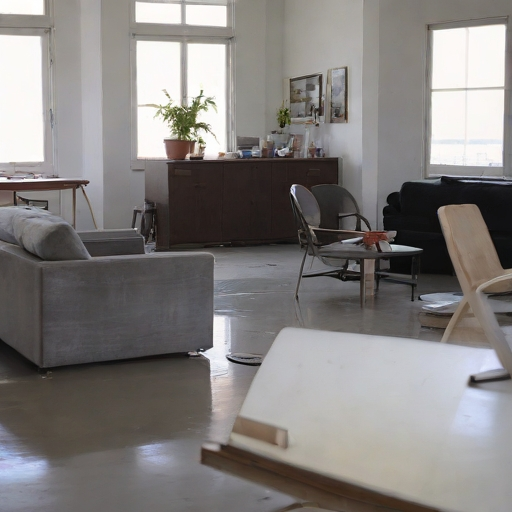

In [2]:
from PIL import Image
from torchvision import transforms

def crop_to_square(image):
    width, height = image.size

    min_side = min(width, height)
    left = (width - min_side) // 2
    top = (height - min_side) // 2
    right = left + min_side
    bottom = top + min_side

    cropped_image = image.crop((left, top, right, bottom))
    return cropped_image

### ============= Load image =============
input_path = './example/input/2.png'

input_image_pil = Image.open(input_path).convert('RGB') # 512x512 
if input_image_pil.size[0] != input_image_pil.size[1]:
    input_image_pil = crop_to_square(input_image_pil)

size = input_image_pil.size
t_val_256 = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC), 
    transforms.ToTensor(),
])
t_val_512 = transforms.Compose([
    transforms.Resize(size, interpolation=transforms.InterpolationMode.BICUBIC), 
])

resized_img = t_val_256(input_image_pil) # 256x256
resized_img = 2.0 * resized_img - 1.0
input_image = transforms.ToTensor()(input_image_pil).unsqueeze(0).to(device) # 512x512
input_image = 2.0 * input_image - 1.0
resized_img = resized_img.unsqueeze(0).to(device)

### ============= Load Message =============
load_text = True
message = 'Hello World!'

if load_text: # text to bits
    if len(message) > 12:
        print('Error: Can only encode 100 bits (12 characters)')
        raise SystemExit
    data = bytearray(message + ' ' * (12 - len(message)), 'utf-8')
    packet_binary = ''.join(format(x, '08b') for x in data)
    watermark = [int(x) for x in packet_binary]
    watermark.extend([0, 0, 0, 0])
    watermark = torch.tensor(watermark, dtype=torch.float).unsqueeze(0)
    watermark = watermark.to(device)
else: # random bits
    data = torch.randint(0, 2, (100,))
    watermark = torch.tensor(data, dtype=torch.float).unsqueeze(0)
    watermark = watermark.to(device)
    
groundtruth_watermark = watermark.clone()

# display the input image
input_image_pil

### Watermark Encoding


Encoding time: 0.4428074359893799 s 
 (Note that please execute multiple times to get the average time)



/home/shilin/anaconda3/envs/vine/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


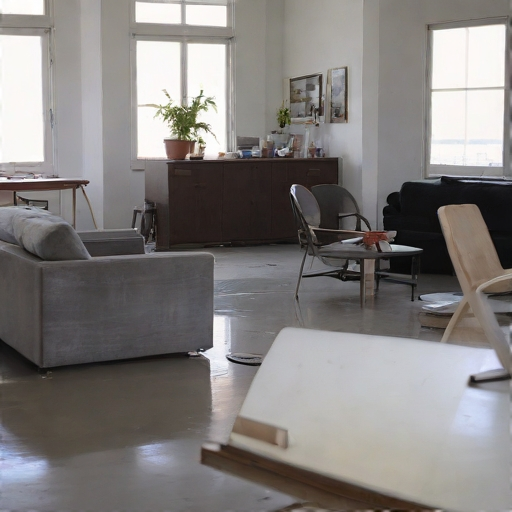

In [3]:
import time

output_dir = './example/watermarked_img'

# watermark encoding
start_time = time.time()
encoded_image_256 = watermark_encoder(resized_img, watermark)
end_time = time.time()
print('\nEncoding time:', end_time - start_time, 's', '\n (Note that please execute multiple times to get the average time)\n')

# resolution scaling to (512x512)
residual_256 = encoded_image_256 - resized_img # 256x256
residual_512 = t_val_512(residual_256) # 512x512
encoded_image = residual_512 + input_image # 512x512
encoded_image = encoded_image * 0.5 + 0.5
encoded_image = torch.clamp(encoded_image, min=0.0, max=1.0)

# save the output image
output_pil = transforms.ToPILImage()(encoded_image[0])
os.makedirs(os.path.join(output_dir), exist_ok=True)
save_loc = os.path.join(output_dir, os.path.split(input_path)[-1][:-4]+'_wm.png')
output_pil.save(save_loc)
gc.collect()
torch.cuda.empty_cache()

# display the watermarked image
output_pil

### Image Editing

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 15.56it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 25/25 [00:02<00:00, 11.77it/s]


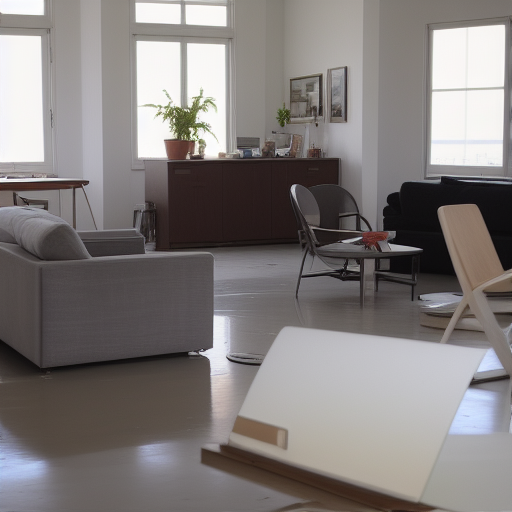

In [4]:
from diffusers import StableDiffusion3InstructPix2PixPipeline, StableDiffusionPipeline, StableDiffusionInstructPix2PixPipeline, DDIMScheduler
from vine.src.editing_pipes import edit_by_UltraEdit, ddim_inversion, edit_by_InstructPix2Pix

model = 'inversion'
example_prompt_list = [
    "change the player's jersey color to blue", # whatever color you want
    "Replace the UK flag with a galaxy filled with stars",
    "Remove all the furniture and replace the concrete floor with a grassy field",
    "Replace the tools with colorful balloons",
    "Change the snowy grass to a frozen lake",
]
edited_output_dir = './example/edited_watermarked_img'
watermarked_img = Image.open(save_loc)

# extract the corresponding prompt
filename = os.path.basename(save_loc)
index = filename.split('_')[0]
prompt = example_prompt_list[int(index)]

if model == 'ultraedit':
    pipe = StableDiffusion3InstructPix2PixPipeline.from_pretrained("BleachNick/SD3_UltraEdit_w_mask",
                                                                    torch_dtype=torch.float16,
                                                                    safety_checker=None,
                                                                    requires_safety_checker=False)    
elif model == 'inversion':
    repo = "CompVis/stable-diffusion-v1-4" # or runwayml/stable-diffusion-v1-5
    pipe = StableDiffusionPipeline.from_pretrained(repo, safety_checker=None, torch_dtype=torch.float32)
elif model == 'instruct-pix2pix':
    pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained("timbrooks/instruct-pix2pix",
                                                                  torch_dtype=torch.float16,
                                                                  safety_checker=None,
                                                                  requires_safety_checker=False)
    pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
else:
    print('Error: Model not found')
    raise SystemExit

pipe.to(device)
if model == 'ultraedit':
    edited_image = edit_by_UltraEdit(pipe, watermarked_img, prompt, text_guidance=7.5, num_inference_steps=50)
elif model == 'inversion':
    edited_image = ddim_inversion(pipe, save_loc, repo, device, inv_type='dpm', dpm_order=2, 
                                  num_steps=25, verify=True, prompt1='', prompt2='')
elif model == 'instruct-pix2pix':
    edited_image = edit_by_InstructPix2Pix(pipe, watermarked_img, prompt, guidance=7.5, num_inference_steps=50)
else:
    print('Error: Model not found')
    raise SystemExit

os.makedirs(os.path.join(edited_output_dir), exist_ok=True)
edited_wm_img_path = os.path.join(edited_output_dir, os.path.split(input_path)[-1][:-4]+'_wm_edit.png')
edited_image.save(edited_wm_img_path)

# display the edited image
edited_image

### Watermark Decoding

In [5]:
import numpy as np

image = Image.open(edited_wm_img_path).convert("RGB")
image = t_val_256(image).unsqueeze(0).to(device)

pred_watermark = decoder(image)
pred_watermark = np.array(pred_watermark[0].cpu().detach())
pred_watermark = np.round(pred_watermark)
pred_watermark = pred_watermark.astype(int)
pred_watermark_list = pred_watermark.tolist()
groundtruth_watermark_list = groundtruth_watermark[0].cpu().detach().numpy().astype(int).tolist()

same_elements_count = sum(x == y for x, y in zip(groundtruth_watermark_list, pred_watermark_list))
acc = same_elements_count / 100

print('Decoding Bit Accuracy:', acc)

Decoding Bit Accuracy: 0.89


### Quality Metrics

In [6]:
import cv2
import torchvision
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import lpips

def compute_psnr_ssim(original_img, watermarked_img):
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    watermarked_img = cv2.cvtColor(watermarked_img, cv2.COLOR_BGR2RGB)
    psnr_value = psnr(original_img, watermarked_img)
    ssim_value, _ = ssim(original_img, watermarked_img, full=True, channel_axis=2)
    print('\nPSNR:', psnr_value)
    print('SSIM:', ssim_value)
    return psnr_value, ssim_value

def compute_lpips(original_img, watermarked_img, loss_fn_alex, device):
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    watermarked_img = cv2.cvtColor(watermarked_img, cv2.COLOR_BGR2RGB)
    original_img = torchvision.transforms.ToTensor()(original_img) * 2 - 1
    watermarked_img = torchvision.transforms.ToTensor()(watermarked_img) * 2 - 1
    original_img = original_img.to(device)
    watermarked_img = watermarked_img.to(device)
    lpips_alex = loss_fn_alex(original_img, watermarked_img)
    print('LPIPS Alex:', lpips_alex.item())
    return lpips_alex.item()

original_img = cv2.imread(input_path, cv2.IMREAD_COLOR)
watermarked_img = cv2.imread(save_loc, cv2.IMREAD_COLOR)
loss_fn_alex = lpips.LPIPS(net='alex').to(device) # best forward scores  
print('\n====================== Image Quality Metrics =======================')
psnr_value, ssim_value = compute_psnr_ssim(original_img, watermarked_img)
lpips_alex = compute_lpips(original_img, watermarked_img, loss_fn_alex, device)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/shilin/anaconda3/envs/vine/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shilin/anaconda3/envs/vine/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/shilin/anaconda3/envs/vine/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth

====================== Image Quality Metrics =======================

PSNR: 42.73041907430951
SSIM: 0.9964163307138181
LPIPS Alex: 0.002101944060996175
